In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from string import punctuation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.tsv', delimiter = '\t')

In [3]:
train.head()
# NOTE: category_name --> string, hierarchical (L->R)
# NOTE: brand_name --> string, can this be boolean?
# NOTE: item_description --> string, needs nlp

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
train.columns

Index([u'train_id', u'name', u'item_condition_id', u'category_name',
       u'brand_name', u'price', u'shipping', u'item_description'],
      dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
train_id,1482535.0,741267.000000,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
item_condition_id,1482535.0,1.907380,0.903159,1.0,1.0,2.0,3.0,5.0
price,1482535.0,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0


In [7]:
five_condition = train[train['item_condition_id'] == 5]
five_condition.head()
# NOTE: item condition is 1-5 scale where 1 is the best and 5 is the worst

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
653,653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet
1027,1027,Broken necklace,5,Women/Jewelry/Necklaces,NaN,20.0,1,"10k gold 18"" chain. Broken at clasp."
2436,2436,Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,NaN,24.0,0,For parts . Turns on and hold battery charge ....
2803,2803,"2 Pounds Of ""Junk"" Jewelry",5,Handmade/Jewelry/Jewelry,NaN,11.0,0,"2 pounds of junk jewelry, There are some items..."


In [8]:
max_price = np.max(train['price'])
most_expensive = train[train['price'] == max_price]
most_expensive
min_price = np.min(train['price'])
least_expensive = train[train['price'] == min_price]
least_expensive.head()
# NOTE: There are a lot of items with no cost (874)
# even though they have good condition and require shipping

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...


In [9]:
len(train['brand_name'].value_counts())

4809

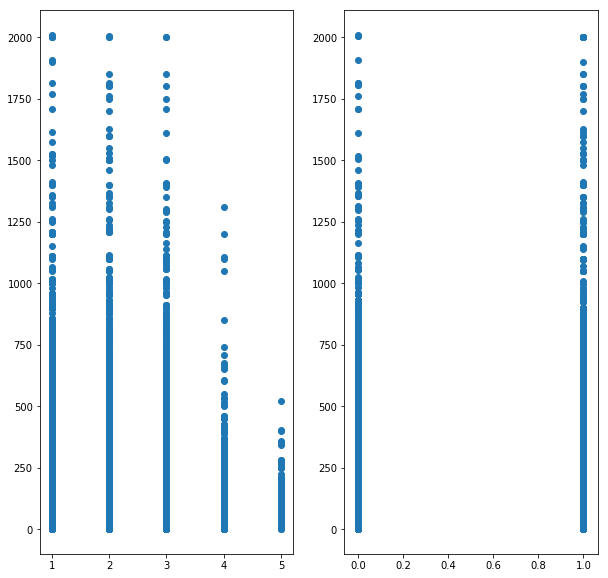

In [10]:
fig, ax_arr = plt.subplots(1,2, figsize=(10,10))
ax_arr[0].scatter(train['item_condition_id'], train['price'])
ax_arr[1].scatter(train['shipping'], train['price'])
plt.show()

In [11]:
no_shipping = np.mean(train[train['shipping'] == 0]['price'])
shipping = np.mean(train[train['shipping'] == 1]['price'])
print ('AVG NO SHIPPING: {}'.format(no_shipping))
print ('AVG WITH SHIPPING: {}'.format(shipping))

AVG NO SHIPPING: 30.1117776273
AVG WITH SHIPPING: 22.5677258332


In [12]:
train['category_name'] = train['category_name'].fillna('None/None/None')
mask = train['category_name'] == 'None/None/None'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,None/None/None,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,None/None/None,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,None/None/None,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,None/None/None,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,None/None/None,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
1274,1274,Black Ribbed Off-the-Shoulder Crop Top,2,None/None/None,Urban Outfitters,15.0,0,From the silence + noise brand sold at Urban O...
1320,1320,Nice Condition Pet Escort,2,None/None/None,PetSafe,12.0,0,Nice condition I will wipe down before selling
1419,1419,3 Toy Bundle,1,None/None/None,NaN,34.0,0,"* brand new/NIB * ** price firm, no free shipp..."
1491,1491,Baby Sign,3,None/None/None,NaN,3.0,1,Magnetic baby sign
1521,1521,Nolan Ryan Patch Baseball Card,2,None/None/None,NaN,3.0,1,No description yet


In [13]:
train['brand_name'] = train['brand_name'].fillna('no_label')
mask = train['brand_name'] == 'no_label'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,no_label,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,no_label,8.0,0,I realized his pants are on backwards after th...
17,17,New: Baby K'tan active baby carrier,1,Kids/Gear/Backpacks & Carriers,no_label,29.0,1,Brand new in box Size: Medium Color: Coral Ret...
23,23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,no_label,8.0,1,Brand new never used All colors are available ...
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
34,34,Four puppy dog stuffed animal ty,3,Kids/Toys/Stuffed Animals & Plush,no_label,5.0,1,2 beanie babies pugsley wrinkles Puppy with pu...
35,35,Black Capri Leggings w/ Flowers One size,1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,13.0,1,One size fits sizes 2-12 92% polyester 8% span...


In [14]:
train['item_description'] = train['item_description'].fillna('No description yet')
mask = train['item_description'] == 'No description yet'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,no_label,5.0,1,No description yet
129,129,Primitive pillow,2,Home/Home Décor/Home Décor Accents,no_label,9.0,0,No description yet
172,172,Toddler Nike tennis shoes,3,Kids/Boys 0-24 Mos/Shoes,Nike,10.0,0,No description yet
195,195,Black Toms,4,Women/Shoes/Loafers & Slip-Ons,no_label,8.0,1,No description yet
214,214,XXS lularoe Carly,1,Women/Dresses/Asymmetrical Hem,no_label,55.0,1,No description yet
218,218,Scentsy testers (36),3,Home/Home Décor/Home Fragrance,Scentsy,21.0,1,No description yet


In [15]:
top, middle, bottom = [], [], []
for i, row in train.iterrows():
    hierarchy_string = row['category_name']
#     print (hierarchy_string)
    hierarchy_list = hierarchy_string.split('/')
#     print ('1: {}, 2: {}, 3: {}'.format(hierarchy_list[0], hierarchy_list[1], hierarchy_list[2]))
    top.append(hierarchy_list[0])
    middle.append(hierarchy_list[1])
    bottom.append(hierarchy_list[2])
train['category_top'] = top
train['category_middle'] = middle
train['category_bottom'] = bottom

In [16]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_top,category_middle,category_bottom
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [17]:
train['category_middle'].value_counts()

Athletic Apparel             134383
Makeup                       124624
Tops & Blouses               106960
Shoes                        100452
Jewelry                       61763
Toys                          58158
Cell Phones & Accessories     53290
Women's Handbags              45862
Dresses                       45758
Women's Accessories           42350
Jeans                         36130
Video Games & Consoles        35971
Sweaters                      35752
Underwear                     33784
Skin Care                     29838
Home Décor                    25188
Fragrance                     24294
Kitchen & Dining              21954
Tops                          20591
Other                         20017
Swimwear                      18924
Men's Accessories             18672
Girls 2T-5T                   18448
Coats & Jackets               18391
Girls 0-24 Mos                17878
Boys 0-24 Mos                 15372
Girls (4+)                    15243
Boys (4+)                   

In [18]:
stop_words = set(stopwords.words('english'))
    
def tokenize(string):
    clean_list = []
    description = string.lower()
    desc_list = description.split()
    for word in desc_list:
        word = word.strip(punctuation)
        if len(word) > 0:
            clean_list.append(word)
    return clean_list

def remove_stopwords(token_list):
    no_stop_words = [word for word in token_list if word not in stop_words]
    return no_stop_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(token_list):
    alphabet = set(['a','b','c','d','e','f','g','h','i','j','k','l','m'
                    'n','o','p','q','r','s','t','u','v','w','x','y','z'])
    lemmatizer = wnl()
    lemmed_tokens = []
    tagged = nltk.pos_tag(token_list)
    for word, pos_tag in tagged:
        word = ''.join([letter for letter in word if letter in alphabet])
        lemmed_word = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos_tag))
        lemmed_tokens.append(lemmed_word)
    return lemmed_tokens

In [19]:
train['description_tokens'] = train['item_description'].apply(lambda x: tokenize(x))

In [ ]:
train['description_tokens'] = train['description_tokens'].apply(lambda x: remove_stopwords(x))

In [ ]:
train['lemmed_tokens'] = train['description_tokens'].apply(lambda x: lemmatize(x))

In [ ]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
vectorizer.fit(train['lemmed_tokens'])
desc_vect = vectorizer.transform(train['lemmed_tokens'])

In [ ]:
no_lem_vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
no_lem_vectorizer.fit(train['description_tokens'])
no_lem_vect = no_lem_vectorizer.transform(train['description_tokens'])

In [ ]:
no_lem_trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
no_lem_trunc_svd.fit(no_lem_vect)
reduced_no_lem_vect = no_lem_trunc_svd.transform(no_lem_vect)

In [ ]:
trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
trunc_svd.fit(desc_vect)
reduced_vect = trunc_svd.transform(desc_vect)

In [ ]:
len(no_lem_vectorizer.vocabulary_)

In [ ]:
len(vectorizer.vocabulary_)

In [ ]:
sum(trunc_svd.explained_variance_ratio_)

In [ ]:
lem_train, lem_test, y_lem_train, y_lem_test = train_test_split(reduced_vect,
                                                                train['price'], test_size=0.2)
no_lem_train, no_lem_test, y_no_lem_train, y_no_lem_test = train_test_split(reduced_no_lem_vect, 
                                                                            train['price'], test_size=0.2)

In [ ]:
rf_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_lem = GradientBoostingRegressor(verbose=3)
rf_no_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_no_lem = GradientBoostingRegressor(verbose=3)
gb_lem.fit(lem_train, y_lem_train)
rf_lem.fit(lem_train, y_lem_train)
gb_no_lem.fit(no_lem_train, y_no_lem_train)
rf_no_lem.fit(no_lem_train, y_no_lem_train)

# SIMILARITY WORK

In [3]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import jaccard_similarity_score as jaccard
from sklearn.metrics.pairwise import pairwise_distances as pw_dist
from sklearn.model_selection import train_test_split

In [4]:
train = pd.read_csv('data/new_features_dropped_zeros.csv')

In [5]:
small_data = train.sample(300000)

In [6]:
brand_dummies = pd.get_dummies(small_data['brand_name'])

In [7]:
cat_top_dummies = pd.get_dummies(small_data['category_top'])

In [8]:
cat_mid_dummies = pd.get_dummies(small_data['category_middle'])

In [9]:
cat_bot_dummies = pd.get_dummies(small_data['category_top'])

In [10]:
train_result = pd.concat([brand_dummies, cat_top_dummies, 
                          cat_mid_dummies, cat_bot_dummies], axis=1, join_axes=[brand_dummies.index])

In [11]:
train_result.shape

(300000, 3100)

In [12]:
brand_dummies.shape[1]+cat_top_dummies.shape[1]+cat_mid_dummies.shape[1]+cat_bot_dummies.shape[1]

3100

In [13]:
X_train, X_test, y_train, y_test= train_test_split(train_result, small_data['price'], test_size=0.2)

In [ ]:
rf = RandomForestRegressor(n_estimators=250, verbose=5, n_jobs=-1)
rf.fit(X_train, y_train)

building tree 1 of 250
building tree 2 of 250
 building tree 3 of 250
building tree 4 of 250 
building tree 5 of 250building tree 6 of 250 

building tree 7 of 250
building tree 8 of 250


In [23]:
def which_leaf(estimator, X):
    ret_mat = np.zeros((X.shape[0],len(estimator.estimators_)))
    for i, tree in enumerate(estimator.estimators_):
        labels = tree.apply(X)
        ret_mat[:,i] = labels
    return ret_mat

In [24]:
def top_n_similar(sim_mat, n_similar):
    idx_top_sim = np.empty((similarity_matrix.shape[0], n_similar))
    for i, row in enumerate(similarity_matrix):
        top_sim = row.argsort()[-n_similar:][::-1]
        idx_top_sim[i] = top_sim
    return idx_top_sim

In [33]:
def jaccard_similarity(leaf_mat):
    similarity_matrix = 1 - pw_dist(leaf_mat, metric='hamming')
    return similarity_matrix

In [26]:
def avg_top_sim(df, idx_top_sim):
    avg_list = []
    for row in idx_top_sim:
        avg_price = np.mean(df.iloc[row]['price'])
        avg_list.append(avg_price)
    return avg_list

In [27]:
def rmsle(pred, actual):
    sle = (np.log10(pred+1) - np.log10(actual+1))**2
    msle = sum(sle)/len(pred)
    rmsle = np.sqrt(msle)
    return rmsle

In [21]:
with open('data/sim_random_forest.pkl', 'wb') as f:
    pkl.dump(rf, f)

In [33]:
test_array.shape

(100000, 2225)

In [30]:
test_result.shape

(100000, 2225)

In [28]:
leaf_mat = which_leaf(rf, X_test)

In [30]:
leaf_mat.shape

(60000, 250)

In [ ]:
sim_mat = jaccard_similarity(leaf_mat)

# Node2Vec

In [59]:
import networkx as netx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
train = pd.read_csv('data/new_features_dropped_zeros.csv')
small_data = train.sample(100000)

In [4]:
graph = netx.from_pandas_dataframe(small_data, 'category_top', 'category_middle')

In [66]:
top_mid = list(zip(small_data.category_top, small_data.category_middle))
mid_bot = list(zip(small_data.category_middle, small_data.category_bottom))
all_zip = list(zip(small_data.category_top, small_data.category_middle, small_data.category_bottom))
all_zip

[('Electronics', 'TV, Audio & Surveillance', 'Portable Audio & Accessories'),
 ('Home', 'Bath', 'Bathroom Accessories'),
 ('Men', "Men's Accessories", 'Hats'),
 ('Electronics', 'Media', 'DVD'),
 ('Women', 'Athletic Apparel', 'Shirts & Tops'),
 ('Other', 'Other', 'Other'),
 ('Beauty', 'Skin Care', 'Face'),
 ('Women', 'Athletic Apparel', 'Pants, Tights, Leggings'),
 ('Women', 'Dresses', 'Knee-Length'),
 ('Men', 'Tops', 'Polo, Rugby'),
 ('Sports & Outdoors', 'Team Sports', 'Soccer'),
 ('Women', 'Dresses', 'Knee-Length'),
 ('Women', 'Athletic Apparel', 'Pants, Tights, Leggings'),
 ('Kids', 'Boys 2T-5T', 'Tops & T-Shirts'),
 ('Women', 'Athletic Apparel', 'Sports Bras'),
 ('Vintage & Collectibles', 'Toy', 'Action Figure'),
 ('Women', 'Tops & Blouses', 'T-Shirts'),
 ('Electronics', 'Cell Phones & Accessories', 'Cases, Covers & Skins'),
 ('Women', 'Tops & Blouses', 'Button Down Shirt'),
 ('Women', 'Tops & Blouses', 'T-Shirts'),
 ('Women', 'Jewelry', 'Rings'),
 ('Women', "Women's Handbags", 'To

In [73]:
small_data['category_bottom'].value_counts()

Pants, Tights, Leggings           4043
Face                              3412
Other                             3381
T-Shirts                          3149
Shoes                             2189
Lips                              2070
Games                             2020
Athletic                          1824
Eyes                              1738
Cases, Covers & Skins             1647
Above Knee, Mini                  1431
Shorts                            1431
Bras                              1419
Necklaces                         1382
Tank, Cami                        1373
Blouse                            1373
Boots                             1339
Makeup Palettes                   1317
Women                             1272
Shirts & Tops                     1142
Shoulder Bag                      1048
Fashion Sneakers                  1033
Sandals                           1020
Tops & T-Shirts                    996
T-shirts                           974
Wallets                  

In [67]:
graph = netx.MultiGraph()
for thing in all_zip:
    graph.add_path(thing)

In [75]:
graph['Other']

{'Accessories': {0: {},
  1: {},
  2: {},
  3: {},
  4: {},
  5: {},
  6: {},
  7: {},
  8: {},
  9: {},
  10: {}},
 'Antique': {0: {}},
 'Apparel': {0: {}},
 'Art': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}},
 'Artwork': {0: {}, 1: {}, 2: {}, 3: {}},
 'Athletic Apparel': {0: {},
  1: {},
  2: {},
  3: {},
  4: {},
  5: {},
  6: {},
  7: {},
  8: {},
  9: {},
  10: {},
  11: {},
  12: {},
  13: {},
  14: {},
  15: {},
  16: {},
  17: {},
  18: {},
  19: {},
  20: {},
  21: {},
  22: {},
  23: {},
  24: {},
  25: {},
  26: {},
  27: {},
  28: {},
  29: {},
  30: {},
  31: {},
  32: {},
  33: {},
  34: {},
  35: {}},
 'Automotive': {0: {},
  1: {},
  2: {},
  3: {},
  4: {},
  5: {},
  6: {},
  7: {},
  8: {},
  9: {},
  10: {},
  11: {},
  12: {},
  13: {},
  14: {},
  15: {},
  16: {},
  17: {},
  18: {},
  19: {},
  20: {},
  21: {},
  22: {},
  23: {},
  24: {},
  25: {},
  26: {},
  27: {},
  28: {},
  29: {},
  30: {},
  31: {},
  32: {},
  33: {},
  34: {},
  35: {},
  36: {},
  3

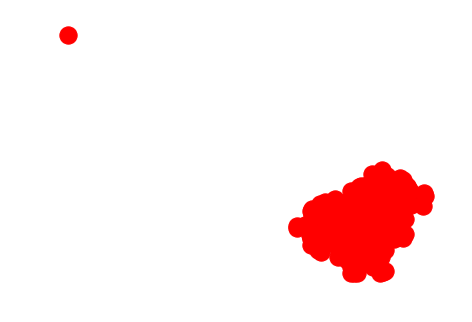

In [78]:
netx.draw(graph, fig_size=(100000,100000))
plt.draw()